# Post-MVP Exploration
In this notebook, I go deeper into the network intrusion dataset to:
1. Visualize additional bivariate feature comparisons
2. Use hypothesis testing to remove non-predictive features
3. Engineer features using a variety of techniques
4. 

# Feature Engineering - Bottom Line Up Front (BLUF)
Below are the candidate features that I will check in a Recursive Feature Elimination (RFE) evaluation for importance in prediction.
- **Non-Zero Duration:** Normal traffic much more likely to be non-zero duration
- **is_UDP:** UDP protocol is near-unanimously Normal
- **is_ICMP:** ICMP protocol is almost entirely Anomalous
- **is_TCP:** TCP is 6x more Normal than Anomalous
- **is_HTTP:** HTTP is near-unanimously and massively Normal
- **is_ECR_I:** ECR-I is near-unanimously and massively Anomalous
- **is_SMTP:** SMTP is near-unanimously and massively Normal
- **is_normal_service:** >70% Normal services determined through exploration
    * ['IRC', 'X11', 'auth', 'domain_u', 'finger', 'ftp', 'ftp_data', 'http', 'ntp_u', 'other', 'pop_3', 'red_i', 'smtp', 'telnet', 'tftp_u', 'tim_i', 'time', 'urh_i', 'urp_i'] 
- **is_anomaly_service:** <30% Normal services determined through exploration
    * ['Z39_50', 'aol', 'bgp', 'courier', 'csnet_ns', 'ctf', 'daytime', 'discard', 'domain', 'echo', 'eco_i', 'ecr_i', 'efs', 'exec', 'gopher', 'harvest', 'hostnames', 'http_443', 'http_8001', 'imap4', 'iso_tsap', 'klogin', 'kshell', 'ldap', 'link', 'login', 'mtp', 'name', 'netbios_dgm', 'netbios_ns', 'netbios_ssn', 'netstat', 'nnsp', 'nntp', 'pm_dump', 'pop_2', 'printer', 'remote_job', 'rje', 'shell', 'sql_net', 'ssh', 'sunrpc', 'supdup', 'systat', 'uucp', 'uucp_path', 'vmnet', 'whois']

In [1]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

import pyspark
spark = pyspark.sql.SparkSession.builder.getOrCreate()
from pyspark.sql.functions import *
from pyspark.sql.types import *

import wrangle

Using Spark's default log4j profile: org/apache/spark/log4j-defaults.properties
Setting default log level to "WARN".
To adjust logging level use sc.setLogLevel(newLevel). For SparkR, use setLogLevel(newLevel).
22/01/27 19:44:33 WARN NativeCodeLoader: Unable to load native-hadoop library for your platform... using builtin-java classes where applicable


In [2]:
df, train = wrangle.prep_explore()

In [3]:
train.show(1, vertical=True)

22/01/27 19:44:48 WARN package: Truncated the string representation of a plan since it was too large. This behavior can be adjusted by setting 'spark.sql.debug.maxToStringFields'.


-RECORD 0--------------------------------
 duration                    | 0         
 protocol_type               | icmp      
 service                     | eco_i     
 flag                        | SF        
 src_bytes                   | 8         
 dst_bytes                   | 0         
 land                        | 0         
 wrong_fragment              | 0         
 urgent                      | 0         
 hot                         | 0         
 num_failed_logins           | 0         
 logged_in                   | 0         
 num_compromised             | 0         
 root_shell                  | 0         
 su_attempted                | 0         
 num_root                    | 0         
 num_file_creations          | 0         
 num_shells                  | 0         
 num_access_files            | 0         
 num_outbound_cmds           | 0         
 is_host_login               | 0         
 is_guest_login              | 0         
 count                       | 1  

# duration

In [4]:
# select columns
duration_target = train.select('duration', 'target').toPandas()

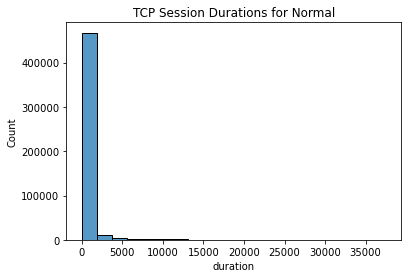

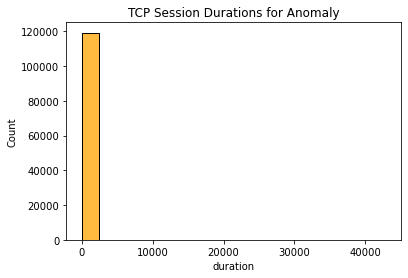

In [5]:
# check histogram of each class for durations
sns.histplot(duration_target[duration_target.target == 'normal'].duration)
plt.title('TCP Session Durations for Normal')
plt.show()

sns.histplot(duration_target[duration_target.target == 'anomalous'].duration, color='orange')
plt.title('TCP Session Durations for Anomaly')
plt.show()

### Histogram Observations
- Duration for both classes seems almost entirely attributed to the near-zero range
- Duration for the Anomalous class might always be zero

Let's check each class without zero-duration observations.

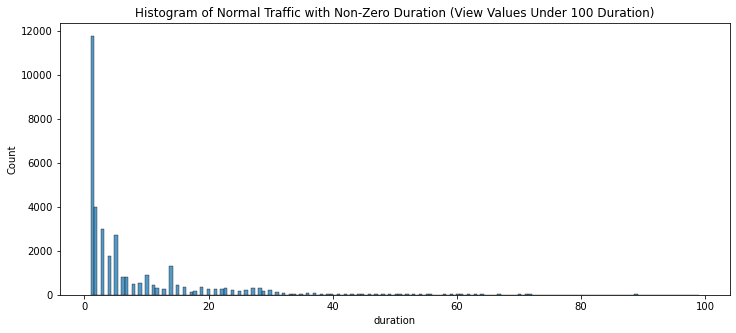

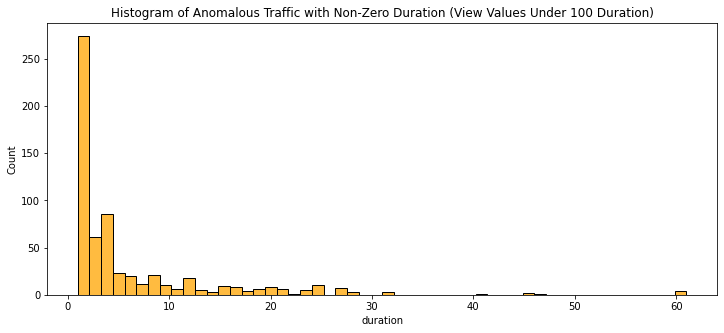

In [6]:
# check if anomaly has durations greater than zero
mask = (duration_target.target == 'normal') & (duration_target.duration > 0) & (duration_target.duration < 100)
plt.figure(figsize=(12,5))
sns.histplot(duration_target[mask].duration)
plt.title('Histogram of Normal Traffic with Non-Zero Duration (View Values Under 100 Duration)')
plt.show()

mask = (duration_target.target == 'anomalous') & (duration_target.duration > 0) & (duration_target.duration < 100)
plt.figure(figsize=(12,5))
sns.histplot(duration_target[mask].duration, color='orange')
plt.title('Histogram of Anomalous Traffic with Non-Zero Duration (View Values Under 100 Duration)')
plt.show()

### Non-Zero Duration Observations
1. Both classes have low value counts at TCP connection durations higher than 10 seconds (5 duration)
2. Nearly all anomalous values are zero-duration TCP connections (shorter than 2 seconds)
    * Domain knowledge: DOS attacks are repeated, short-duration TCP connections
    * Domain knowledge: Illicit activity and attempts are often low-duration TCP connections due to various factors
3. Normal-class durations are mostly zero but not as dense in zero-duration TCP connections
    * Domain knowledge: Longer-duration TCP connections are often for various services conducted legitimately
4. Normal connections have tens of thousands of non-zero durations; anomalous conenctions have less than a thousand

## Duration Takeaways
- Both classes have most observations with zero duration for TCP connections
- Durations above zero are much more likely to be legitimate
- **Feature Engineering: One-hot for duration > 0**

# protocol_type

In [7]:
# use Spark groupby to create barplot specifications
protocol_type_target = train.groupBy('target', 'protocol_type')\
    .agg(count('target').alias('count_target')).toPandas()
protocol_type_target

22/01/27 19:45:20 WARN RowBasedKeyValueBatch: Calling spill() on RowBasedKeyValueBatch. Will not spill but return 0.
22/01/27 19:45:20 WARN RowBasedKeyValueBatch: Calling spill() on RowBasedKeyValueBatch. Will not spill but return 0.
22/01/27 19:45:20 WARN RowBasedKeyValueBatch: Calling spill() on RowBasedKeyValueBatch. Will not spill but return 0.
22/01/27 19:45:21 WARN RowBasedKeyValueBatch: Calling spill() on RowBasedKeyValueBatch. Will not spill but return 0.
22/01/27 19:45:24 WARN RowBasedKeyValueBatch: Calling spill() on RowBasedKeyValueBatch. Will not spill but return 0.


,target,protocol_type,count_target
0,normal,udp,95493
1,normal,icmp,6475
2,anomalous,icmp,76632
3,normal,tcp,384882
4,anomalous,tcp,41776
5,anomalous,udp,1443


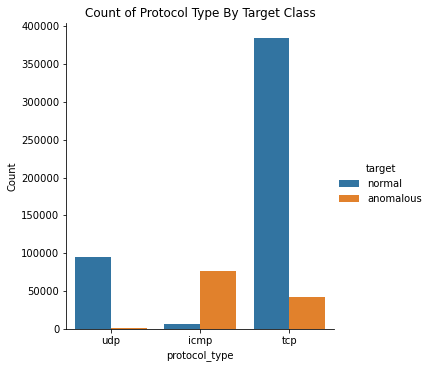

In [8]:
# plot counts
sns.catplot(data=protocol_type_target, x='protocol_type', y='count_target', hue='target', kind='bar')
plt.title('Count of Protocol Type By Target Class')
plt.ylabel('Count')
plt.show()

## Protocol Type Takeaways
1. Each protocol type has vastly different counts between Normal and Anomaly observations
    * **Protocol Type, therefore, is an excellent predictive candidate**
2. UDP is near-universally a Normal protocol
3. ICMP is on the order of 10:1 ratio for Anomaly:Normal
4. TCP is close to 1:6 ratio for Anomaly:Normal
5. **Feature Engineering: is_UDP, is_ICMP, is_TCP**

# service

In [9]:
# use Spark groupby to create barplot specifications
service_target = train.groupBy('target', 'service')\
    .agg(count('target').alias('count_target')).toPandas()
service_target

22/01/27 19:45:32 WARN RowBasedKeyValueBatch: Calling spill() on RowBasedKeyValueBatch. Will not spill but return 0.
22/01/27 19:45:32 WARN RowBasedKeyValueBatch: Calling spill() on RowBasedKeyValueBatch. Will not spill but return 0.
22/01/27 19:45:32 WARN RowBasedKeyValueBatch: Calling spill() on RowBasedKeyValueBatch. Will not spill but return 0.
22/01/27 19:45:34 WARN RowBasedKeyValueBatch: Calling spill() on RowBasedKeyValueBatch. Will not spill but return 0.
22/01/27 19:45:36 WARN RowBasedKeyValueBatch: Calling spill() on RowBasedKeyValueBatch. Will not spill but return 0.


,target,service,count_target
0,anomalous,imap4,45
1,anomalous,login,29
2,anomalous,daytime,42
3,anomalous,http,1134
4,anomalous,telnet,118
...,...,...,...
86,normal,tim_i,3
87,normal,red_i,6
88,anomalous,http_8001,2
89,anomalous,aol,1


In [10]:
# limit options to main services
service_target_over_1000 = service_target[service_target.count_target > 1000]\
    .sort_values(by='target', ascending=False)
service_target_over_1000

,target,service,count_target
73,normal,eco_i,1879
65,normal,http,310105
19,normal,ftp_data,18978
23,normal,private,37000
32,normal,auth,1166
43,normal,urp_i,2751
45,normal,domain_u,28819
69,normal,ntp_u,1881
50,normal,ecr_i,1769
17,normal,other,28120


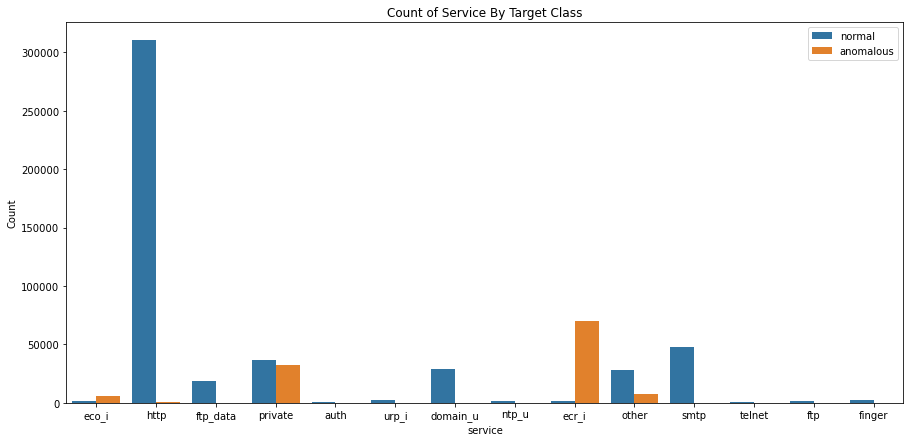

In [11]:
# plot counts
plt.figure(figsize=(15,7))
sns.barplot(data=service_target_over_1000, x='service', y='count_target', hue='target')
plt.title('Count of Service By Target Class')
plt.ylabel('Count')
plt.legend(loc='upper right')
plt.show()

### Bar Plot Observations
1. HTTP is near-unanimously Normal, and massively significant
2. ECR-I has nearly 75,000 observations and is almost entirely Anomalous
3. SMTP is around 50,000 observations and almost entirely Normal
4. From a cursory look, most other services are mostly Normal, split on Normal or Anomalous, or too-low value count

Let's look at the ratios on each service with less than 50,000 observations in a class. (This eliminates the services we've already taken down in the above observations.) 

The goal is to determine which features are mostly-Normal (>70%) so that we can group the services into a single feature for is_normal_service.

In [12]:
# groupby
service_totals = pd.DataFrame(service_target\
                              .groupby('service')\
                              .count_target\
                              .sum())
service_totals.head(3)

,count_target
service,
IRC,255
X11,69
Z39_50,34


In [13]:
# loop services in un-grouped using mask for Normal, use .loc to add to new column in grouped
norm_tgt_mask = service_target.target == 'normal'
for srv in service_target[norm_tgt_mask].service.unique():
    srv_mask = service_target.service == srv
    count_normal = service_target[norm_tgt_mask & srv_mask].count_target.item()
    service_totals.loc[srv, 'count_normal'] = count_normal

service_totals.head(3)

,count_target,count_normal
service,,
IRC,255,254.0
X11,69,68.0
Z39_50,34,NaN


In [14]:
# fill nulls with 0, since a null value in count_normal indicates zero observations for that service and Normal
service_totals = service_totals.fillna(0).astype('int')
service_totals.head(3)

,count_target,count_normal
service,,
IRC,255,254
X11,69,68
Z39_50,34,0


In [15]:
# create ratio column of normal / total count
service_totals['ratio_normal'] = (service_totals.count_normal / 
                                            service_totals.count_target).round(3)
service_totals.head(3)

,count_target,count_normal,ratio_normal
service,,,
IRC,255,254,0.996
X11,69,68,0.986
Z39_50,34,0,0.000


In [16]:
# add bool columns indicating if ratio higher than 0.7 or lower than 0.3
service_totals['is_normal'] = service_totals.ratio_normal > 0.7
service_totals['is_anomalous'] = service_totals.ratio_normal < 0.3
service_totals.head(3)

,count_target,count_normal,ratio_normal,is_normal,is_anomalous
service,,,,,
IRC,255,254,0.996,True,False
X11,69,68,0.986,True,False
Z39_50,34,0,0.000,False,True


In [17]:
# print list of services that are >70% normal and list of services that are <30% normal
normal_services = service_totals[service_totals.is_normal].index.tolist()
anomaly_services = service_totals[service_totals.is_anomalous].index.tolist()
print("Normal services:\n", normal_services, "\n")
print("Anomaly services:\n", anomaly_services)

Normal services:
 ['IRC', 'X11', 'auth', 'domain_u', 'finger', 'ftp', 'ftp_data', 'http', 'ntp_u', 'other', 'pop_3', 'red_i', 'smtp', 'telnet', 'tftp_u', 'tim_i', 'time', 'urh_i', 'urp_i'] 

Anomaly services:
 ['Z39_50', 'aol', 'bgp', 'courier', 'csnet_ns', 'ctf', 'daytime', 'discard', 'domain', 'echo', 'eco_i', 'ecr_i', 'efs', 'exec', 'gopher', 'harvest', 'hostnames', 'http_443', 'http_8001', 'imap4', 'iso_tsap', 'klogin', 'kshell', 'ldap', 'link', 'login', 'mtp', 'name', 'netbios_dgm', 'netbios_ns', 'netbios_ssn', 'netstat', 'nnsp', 'nntp', 'pm_dump', 'pop_2', 'printer', 'remote_job', 'rje', 'shell', 'sql_net', 'ssh', 'sunrpc', 'supdup', 'systat', 'uucp', 'uucp_path', 'vmnet', 'whois']


## Service Takeaways
1. Service-by-Class counts indicate large count disparities between each service's class observations
2. **Feature Engineering: is_normal_service, is_anomaly_service**